# Popgen stats for G. wheatlandi 

## ToC
* [Introduction](#Introduction)
* [Functions](#Functions)
* [Analyses](#Analyses)
     * [G. wheatlandi](#G.wheatlandi)
         * [Chromosome X19](#GwX19)
             * [Coverage](#GwX19_coverage)
             
         * [Chromosome X12](#GwX12)
             
* [EXTRA](#EXTRA)
    * [G. aculeatus ChrXIX analyses with Het probabilities](#Ga_chr19_het_probs)
    * [Chr11 inversion](#Ga_chr11_inversion)

                    
                    
                    
                    
                    
                    


# Introduction

Here we will calculate the sequencing and popgen stats to plot against the Gw genome reference. Stats were calculated from a popualtion sample of blackpotted stickleback. 


# Functions

In [1]:
%%html
<style>
table {align:left; display:block}
</style>

In [158]:
def Plot_M_F_Fst(infilepath, outfilepath = None, 
                 sex_scaffs = None, auto_scaffs = [], 
                 figlims = (20,5), 
                 rolling_avg = True, rolling_colour = "black", roll = 10, moving_average_offset = 2500,
                 points = True, points_color = "blue", points_alpha = 0.5,                  
                 autoAvg = True, autoAvg_color = "darkblue", autoAvg_alpha = 0.5, autoAvg_linestyle = "dashed",
                 vert_seps = None, vert_seps_color = "darkblue", vert_seps_alpha = 0.5, vert_seps_linestyle = "dashed",
                 myXlims = None, myYlims_ax1 = None,
                 y_label = "Label me!"):

    """
    
    """
    
    import sys
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 14})
    
    Scaff_dict = {}

    with open(infilepath) as MvF_Fst:

        header = next(MvF_Fst)
        
        for line in MvF_Fst:

            scaff = line.split()[0]
            start = int(float(line.split()[1]))
            stop = int(float(line.split()[2]))
            centre = start + ((stop-start)/2)
            n_snps = int(float(line.split()[3]))
            fst = float(line.split()[4])
            weighted_fst = float(line.split()[5])
            
            if scaff not in Scaff_dict:
                Scaff_dict[scaff] = {}
                Scaff_dict[scaff]["centre"] = []
                Scaff_dict[scaff]["n_snps"] = []
                Scaff_dict[scaff]["fst"] = []
                Scaff_dict[scaff]["weighted_fst"] = []
                
            if n_snps >= 5:
                
                Scaff_dict[scaff]["centre"].append(centre)
                Scaff_dict[scaff]["n_snps"].append(n_snps)
                Scaff_dict[scaff]["fst"].append(fst)
                Scaff_dict[scaff]["weighted_fst"].append(weighted_fst)
    
    if sex_scaffs:
        scaffs_to_plot = sex_scaffs
    else:
        scaffs_to_plot = sorted(Scaff_dict.keys())
    
    ## get autosomal fst average
    if all([autoAvg, len(auto_scaffs) > 0]):
        auto_fsts = []
        for scaff in Scaff_dict:
            if scaff in auto_scaffs:
                auto_fsts + Scaff_dict[scaff]["fst"]

        Avg_auto_fst = np.round(np.mean(auto_fsts),2)  ## plot this later
    
    
    print("Plotting scaffolds: %s" % ", ".join(scaffs_to_plot))
  
    plt.figure(figsize = (figlims[0],figlims[1]*len(scaffs_to_plot)))
    
    scaff_index = 1
       
    for scaff in scaffs_to_plot:
    
        df = pd.DataFrame() ## initiate dataframe to catch outputs

        ax1 = plt.subplot(len(scaffs_to_plot),1,scaff_index) ## initiate plot object
            
        fst_pddf = pd.DataFrame(Scaff_dict[scaff]["fst"], dtype='float64')
        rolling_fst = fst_pddf.rolling(roll, min_periods=1).mean()
        
        if points == True:
            ax1.scatter([i/1000000 for i in Scaff_dict[scaff]["centre"]],
                        fst_pddf, 
                        c = points_color, 
                        s = 5, 
                        alpha = points_alpha)
                        
        if rolling_avg:
            ax1.plot([(i-moving_average_offset)/1000000 for i in Scaff_dict[scaff]["centre"]], 
                     rolling_fst, 
                     c = rolling_colour, 
                     linewidth = 1, 
                     alpha = 1)

        ## control axis limits
            
        if myXlims:
            min_x = myXlims[0]
            max_x = myXlims[1]
            ax1.set_xlim(min_x, max_x)
                
        if myYlims_ax1:
            min_y = myYlims_ax1[0]
            max_y = myYlims_ax1[1]
            ax1.set_ylim(min_y, max_y)
                
        ## Set axis labels
            
        ax1.set_ylabel(y_label)
            
        ## catch outputs
                
        df["Chromosomes"] = [scaff]*len(fst_pddf)  ## this df will get made several times if more than one plot is requested, but makes no difference. 
        df["Window_centres"] = [(i)/1000000 for i in Scaff_dict[scaff]["centre"]]
        df["fst"] = fst_pddf
        df["Rolling_fst"] = rolling_fst
                   
        ### Add the autosomal genome average

        if all([autoAvg, len(auto_scaffs) > 0]):

            ax1.hlines(Avg_auto_fst, 
                       min_x,
                       max_x,
                       linestyles = autoAvg_linestyle,
                       colors = autoAvg_color,
                       alpha = autoAvg_alpha)

        ## Add separators if specified
        
        if vert_seps:
            
            if not myYlims_ax1:
                    sys.exit("Need Ylims for ax1 for separator lines")
            
            for x_coord in vert_seps:
                              
                ax1.vlines(x_coord, 
                           min_y, 
                           max_y, 
                           linestyles = vert_seps_linestyle,
                           colors = vert_seps_color,
                           alpha = vert_seps_alpha)
            
        scaff_index += 1

    if outfilepath:
        plt.savefig(outfilepath)
    else:
        plt.savefig("%s_plot.pdf" % infilepath.rpartition(".")[0])
        
    plt.show()
    
    positions = [i/1000000 for i in Scaff_dict[scaff]["centre"]]
    
    return positions, fst_pddf

    


In [277]:
def Plot_M_F_dNdS(infilepath, outfilepath = None, 
                  sex_scaffs = None, auto_scaffs = [], 
                  figlims = (20,5), 
                  rolling_avg = True, rolling_colour = "black", roll = 10, moving_average_offset = 2500,
                  strata_avgs = None, strata_avg_color = "red", strata_avg_alpha = 0.5, strata_avg_linestyle = "dashed", 
                  points = True, points_color = "blue", points_alpha = 0.5,                  
                  autoAvg = True, autoAvg_color = "darkblue", autoAvg_alpha = 0.5, autoAvg_linestyle = "dashed",
                  vert_seps = None, vert_seps_color = "darkblue", vert_seps_alpha = 0.5, vert_seps_linestyle = "dashed",
                  myXlims = None, myYlims_ax1 = None,
                  y_label = "Label me!"):

    """
    
    """
    
    import sys
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 14})
    
    Scaff_dict = {}

    with open(infilepath) as dNdS_handle:
        
        header = next(dNdS_handle)

        for line in dNdS_handle:

            scaff = line.split()[0]

            if scaff not in Scaff_dict:
                Scaff_dict[scaff] = {}
                Scaff_dict[scaff]["pos"] = []
                Scaff_dict[scaff]["dNdS"] = []

            
            ## Check for and remove for high ratios from genes with dN = 0 and dS = 0
            
            Scaff_dict[scaff]["pos"].append(int(float(line.split()[1])))
                
            if "NA" in line:
                Scaff_dict[scaff]["dNdS"].append(np.nan)
            else:
                Scaff_dict[scaff]["dNdS"].append(float(line.split()[6]))


    output_DF = pd.DataFrame()
    
    if sex_scaffs:
        scaffs_to_plot = sex_scaffs
    else:
        scaffs_to_plot = sorted(Scaff_dict.keys())
    
    ## get autosomal fst average
    if all([autoAvg, len(auto_scaffs) > 0]):
        auto_fsts = []
        for scaff in Scaff_dict:
            if scaff in auto_scaffs:
                auto_fsts + Scaff_dict[scaff]["fst"]

        Avg_auto_fst = np.round(np.mean(auto_fsts),2)  ## plot this later
    
    
    print("Plotting scaffolds: %s" % ", ".join(scaffs_to_plot))
  
    plt.figure(figsize = (figlims[0],figlims[1]*len(scaffs_to_plot)))
    
    scaff_index = 1
       
    for scaff in scaffs_to_plot:
    
        df = pd.DataFrame() ## initiate dataframe to catch outputs

        ax1 = plt.subplot(len(scaffs_to_plot),1,scaff_index) ## initiate plot object
            
        dNdS_pddf = pd.DataFrame(Scaff_dict[scaff]["dNdS"], dtype='float64')
        rolling_dNdS = dNdS_pddf.rolling(roll, min_periods=1).mean()
        
        if points == True:
            ax1.scatter([i/1000000 for i in Scaff_dict[scaff]["pos"]],
                        dNdS_pddf, 
                        c = points_color, 
                        s = 5, 
                        alpha = points_alpha)
                        
        if rolling_avg:
            ax1.plot([(i-moving_average_offset)/1000000 for i in Scaff_dict[scaff]["pos"]], 
                     rolling_dNdS, 
                     c = rolling_colour, 
                     linewidth = 1, 
                     alpha = 1)

        ## control axis limits
            
        if myXlims:
            min_x = myXlims[0]
            max_x = myXlims[1]
            ax1.set_xlim(min_x, max_x)
                
        if myYlims_ax1:
            min_y = myYlims_ax1[0]
            max_y = myYlims_ax1[1]
            ax1.set_ylim(min_y, max_y)
                
        ## Set axis labels
            
        ax1.set_ylabel(y_label)
            
        ## catch outputs
                
        df["Chromosomes"] = [scaff]*len(dNdS_pddf)  ## this df will get made several times if more than one plot is requested, but makes no difference. 
        df["Positions"] = [(i)/1000000 for i in Scaff_dict[scaff]["pos"]]
        df["dNdS"] = dNdS_pddf
        df["Rolling_dNdS"] = rolling_dNdS
                   
        ### Add the autosomal genome average

        if all([autoAvg, len(auto_scaffs) > 0]):

            ax1.hlines(Avg_auto_fst, 
                       min_x,
                       max_x,
                       linestyles = autoAvg_linestyle,
                       colors = autoAvg_color,
                       alpha = autoAvg_alpha)

        ## Add separators if specified
        
        if vert_seps:
            
            if not myYlims_ax1:
                    sys.exit("Need Ylims for ax1 for separator lines")
            
            for x_coord in vert_seps:
                              
                ax1.vlines(x_coord, 
                           min_y, 
                           max_y, 
                           linestyles = vert_seps_linestyle,
                           colors = vert_seps_color,
                           alpha = vert_seps_alpha)
                    
        if strata_avgs:
            
            dNdS_pddf.insert(0,"pos",[i/1000000 for i in Scaff_dict[scaff]["pos"]])
            
            Stratum_dict = {}
            stratum_index = 1
            
            for stratum in strata_avgs:
                
                stratum_name = "S%s" % stratum_index
                
                start = stratum[0]
                stop = stratum[1]
                
                Stratum_dict[stratum_name] = dNdS_pddf[dNdS_pddf['pos'].between(start, stop)]
                
                ## plot hlines
                
                plt.hlines(np.mean(Stratum_dict[stratum_name]),
                          start,
                          stop,
                          linestyles=strata_avg_linestyle,
                          alpha = strata_avg_alpha,
                          colors = strata_avg_color)
                          
                stratum_index += 1
        
        
        scaff_index += 1

    if outfilepath:
        plt.savefig(outfilepath)
    else:
        plt.savefig("%s_plot.pdf" % infilepath.rpartition(".")[0])
        
    plt.show()
    

    


In [292]:
def Plot_M_F_dS(infilepath, outfilepath = None, 
                  sex_scaffs = None, auto_scaffs = [], 
                  figlims = (20,5), 
                  rolling_avg = True, rolling_colour = "black", roll = 10, moving_average_offset = 2500,
                  strata_avgs = None, strata_avg_color = "red", strata_avg_alpha = 0.5, strata_avg_linestyle = "dashed", 
                  points = True, points_color = "blue", points_alpha = 0.5,                  
                  autoAvg = True, autoAvg_color = "darkblue", autoAvg_alpha = 0.5, autoAvg_linestyle = "dashed",
                  vert_seps = None, vert_seps_color = "darkblue", vert_seps_alpha = 0.5, vert_seps_linestyle = "dashed",
                  myXlims = None, myYlims_ax1 = None,
                  y_label = "Label me!"):

    """
    Just plotting dS here
    """
    
    import sys
    import numpy as np
    import pandas as pd
    from matplotlib import pyplot as plt
    
    plt.rcParams["font.family"] = "Times New Roman"
    plt.rcParams.update({'font.size': 14})
    
    Scaff_dict = {}

    with open(infilepath) as dNdS_handle:
        
        header = next(dNdS_handle)

        for line in dNdS_handle:

            scaff = line.split()[0]

            if scaff not in Scaff_dict:
                Scaff_dict[scaff] = {}
                Scaff_dict[scaff]["pos"] = []
                Scaff_dict[scaff]["dNdS"] = []
                Scaff_dict[scaff]["dN"] = []
                Scaff_dict[scaff]["dS"] = []
            
            ## Check for and remove for high ratios from genes with dN = 0 and dS = 0
            
            Scaff_dict[scaff]["pos"].append(int(float(line.split()[1])))
                
            dS = line.split()[5]
            if dS == "NA":
                Scaff_dict[scaff]["dS"].append(np.nan)
                    
            else:             
                Scaff_dict[scaff]["dS"].append(float(line.split()[5]))

    output_DF = pd.DataFrame()
    
    if sex_scaffs:
        scaffs_to_plot = sex_scaffs
    else:
        scaffs_to_plot = sorted(Scaff_dict.keys())
    
    
    print("Plotting scaffolds: %s" % ", ".join(scaffs_to_plot))
  
    plt.figure(figsize = (figlims[0],figlims[1]*len(scaffs_to_plot)))
    
    scaff_index = 1

    
    for scaff in scaffs_to_plot:
    
        df = pd.DataFrame() ## initiate dataframe to catch outputs

        ax1 = plt.subplot(len(scaffs_to_plot),1,scaff_index) ## initiate plot object
            
        dS_pddf = pd.DataFrame(Scaff_dict[scaff]["dS"], dtype='float64')
        rolling_dS = dS_pddf.rolling(roll, min_periods=1).mean()
        
        if points == True:
            ax1.scatter([i/1000000 for i in Scaff_dict[scaff]["pos"]],
                        dS_pddf, 
                        c = points_color, 
                        s = 5, 
                        alpha = points_alpha)
                        
        if rolling_avg:
            ax1.plot([(i-moving_average_offset)/1000000 for i in Scaff_dict[scaff]["pos"]], 
                     rolling_dS, 
                     c = rolling_colour, 
                     linewidth = 1, 
                     alpha = 1)

        ## control axis limits
            
        if myXlims:
            min_x = myXlims[0]
            max_x = myXlims[1]
            ax1.set_xlim(min_x, max_x)
                
        if myYlims_ax1:
            min_y = myYlims_ax1[0]
            max_y = myYlims_ax1[1]
            ax1.set_ylim(min_y, max_y)
                
        ## Set axis labels
            
        ax1.set_ylabel(y_label)
            
        ## catch outputs
                
        df["Chromosomes"] = [scaff]*len(dS_pddf)  ## this df will get made several times if more than one plot is requested, but makes no difference. 
        df["Positions"] = [(i)/1000000 for i in Scaff_dict[scaff]["pos"]]
        df["dS"] = dS_pddf
        df["Rolling_dS"] = rolling_dS
                   
        ### Add the autosomal genome average

        if all([autoAvg, len(auto_scaffs) > 0]):

            ax1.hlines(Avg_auto_fst, 
                       min_x,
                       max_x,
                       linestyles = autoAvg_linestyle,
                       colors = autoAvg_color,
                       alpha = autoAvg_alpha)

        ## Add separators if specified
        
        if vert_seps:
            
            if not myYlims_ax1:
                    sys.exit("Need Ylims for ax1 for separator lines")
            
            for x_coord in vert_seps:
                              
                ax1.vlines(x_coord, 
                           min_y, 
                           max_y, 
                           linestyles = vert_seps_linestyle,
                           colors = vert_seps_color,
                           alpha = vert_seps_alpha)
                    
        
        if strata_avgs:
            
            dS_pddf.insert(0,"pos",[i/1000000 for i in Scaff_dict[scaff]["pos"]])
            
            Stratum_dict = {}
            stratum_index = 1
            
            for stratum in strata_avgs:
                
                stratum_name = "S%s" % stratum_index
                
                start = stratum[0]
                stop = stratum[1]
                
                Stratum_dict[stratum_name] = dS_pddf[dS_pddf['pos'].between(start, stop)]
                
                ## plot hlines
                
                plt.hlines(np.mean(Stratum_dict[stratum_name]),
                          start,
                          stop,
                          linestyles=strata_avg_linestyle,
                          alpha = strata_avg_alpha,
                          colors = strata_avg_color)
                          
                stratum_index += 1
    
        
        scaff_index += 1

    if outfilepath:
        plt.savefig(outfilepath)
    else:
        plt.savefig("%s_plot.pdf" % infilepath.rpartition(".")[0])
        
    plt.show()
    
    #return Stratum_dict
    


# Analyses <a class="anchor" id="Analyses"></a>

In [1243]:
Ga_AutoX_male_hets_path = "/Users/dj20y461/Data_temp/Stickleback/Y_comp/2n_windows/Ga/Autos_X/VCF_STATS/Ga_Autos_X_males.hwe"

Ga_chrXIX_cov_het_dict = Combine_covs_hets(plot_data_out_Ga_ALL, 
                                           Ga_AutoX_male_hets_path, 
                                           min_male_hets=1)

I will plot some histograms first, to see how the two distributions look and to help make decisions on cutoffs later

In [1244]:
## make the data for plotting (get heterozygosity means and track positions for the colours). 

Ga_AutoX_hets = []
Ga_AutoX_covs = []
Ga_AutoX_poss = [] ## for keeping track of positions

chrom = "chrXIX"
for window in het_cov_dict[chrom]:
    Ga_AutoX_poss.append(window)
    Ga_AutoX_hets.append(np.mean(het_cov_dict[chrom][window]["hets"]))
    Ga_AutoX_covs.append(het_cov_dict[chrom][window]["M_F_cov"])
                 


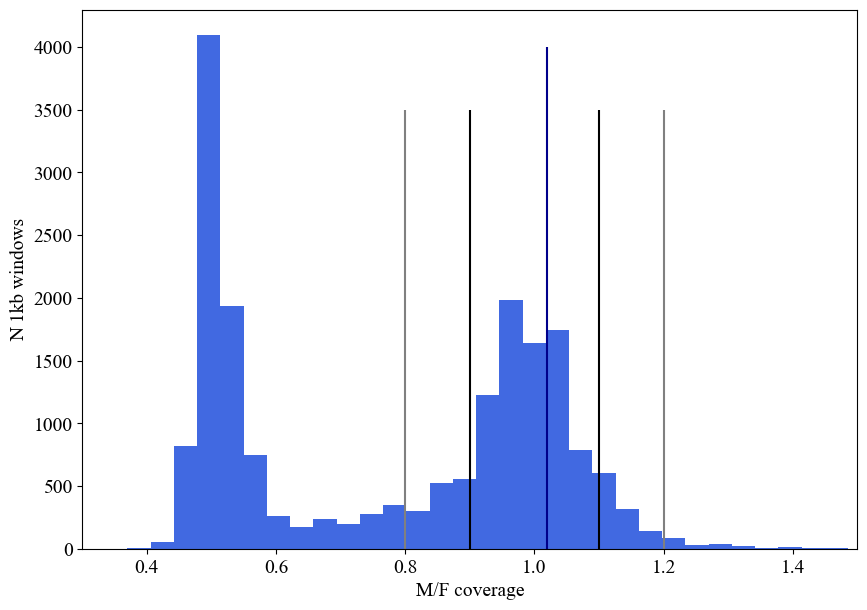

In [1247]:
fig = plt.figure(figsize=(10,7))

plt.hist(Ga_AutoX_covs, bins = 50, color = "royalblue")
plt.xlim(0.3,1.5)
plt.ylabel("N 1kb windows")
plt.xlabel("M/F coverage")

## plot autosomal mean

plt.vlines(1.02,0,4000, color = "darkblue")

## plot lines to show the loose cutoffs
plt.vlines(0.8,0,3500, color = "grey")
plt.vlines(1.2,0,3500, color = "grey")

## plot lines to show the tight cutoffs
plt.vlines(0.9,0,3500, color = "black")
plt.vlines(1.1,0,3500, color = "black")

plt.savefig("/Users/dj20y461/Data_temp/Stickleback/Y_comp/2n_windows/Ga/Autos_X/MF_cov_per_1kb_window.pdf")
plt.show()

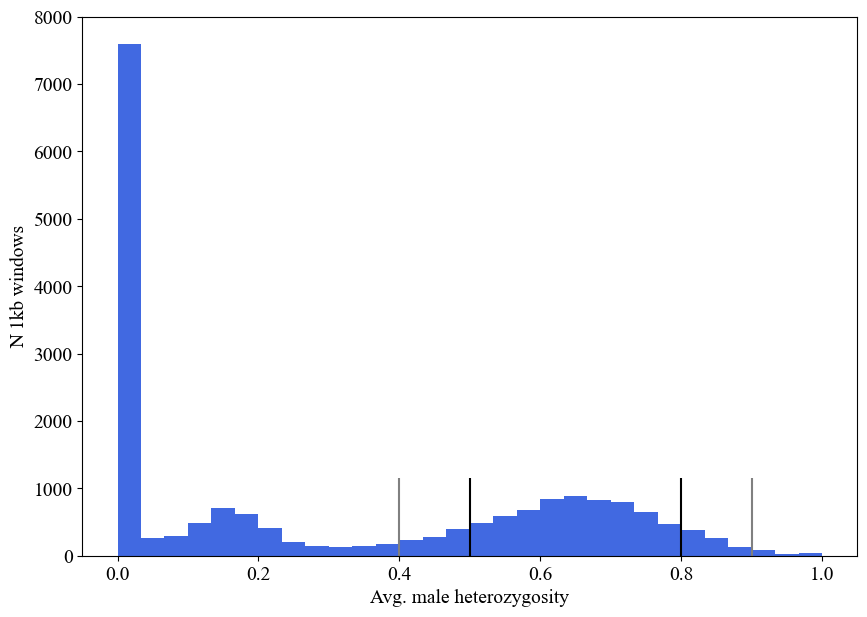

In [1250]:
fig = plt.figure(figsize=(10,7))
plt.hist(Ga_AutoX_hets, bins = 30, color = "royalblue")
plt.ylim(0,8000)  ## note the 0 bar goes much higher

## plot lines to show the loose cutoffs
plt.vlines(0.4,0,1150, color = "grey")
plt.vlines(0.9,0,1150, color = "grey")

## plot lines to show the tight cutoffs
plt.vlines(0.5,0,1150, color = "black")
plt.vlines(0.8,0,1150, color = "black")

plt.ylabel("N 1kb windows")
plt.xlabel("Avg. male heterozygosity")

plt.savefig("/Users/dj20y461/Data_temp/Stickleback/Y_comp/2n_windows/Ga/Autos_X/Male_het_per_1kb_window.pdf")
plt.show()

***Quick plot of distribution of heterozygostiy along the chromosome***

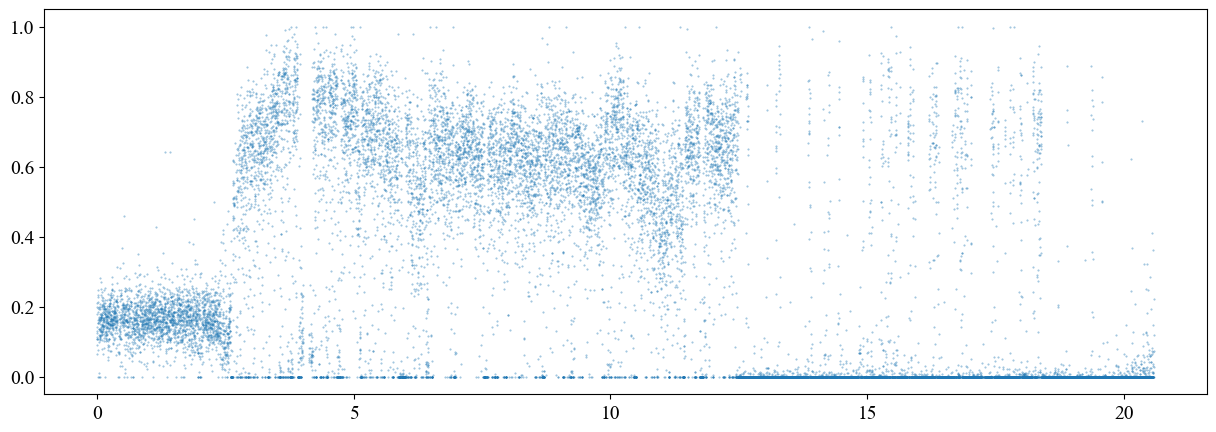

In [1217]:
plt.figure(figsize = (15,5))
plt.scatter(pos, hets, s=0.2, alpha = 0.5)
plt.show()

## G. wheatlandi <a id="G.wheatlandi"></a>

In [23]:
## make lists of males, females and scaffold IDs

Gw_males  = ["2003ME_M_2","2003ME_M_4","2003QE_M_1","2003QE_M_2","2007MA_M_1","2007MA_M_2","2007MA_M_3","Gw02_M","Gw04_M",
              "Gw05_M","Gw08_M","Gw10a_M","Gw11a_M","Gw12_M","Gw14_M","Gw15_M","Gw16_M","Gw17_M","Gw1a_M","Gw2a_M","Gw4a_M",
              "Gw5a_M","Gw6a_M","Gw7a_M","Gw8a_M","Gw9a_M"]
    
Gw_females = ["2003QE_F_3","2003QE_F_5","2007MA_F_1","2007MA_F_2","2007MA_F_3","Gw01_F","Gw03_F","Gw06_F","Gw07_F","Gw14_01f_F"]

Gw_scaffs = ["chr1","chr2","chr3","chr4","chr5","chr6","chr7","chr8","chr9","chr10","chr11","chr12","chr13","chr14","chr15",
             "chr16","chr17","chr18","chr19","chr20","chr21"]


### Plotting M vs F Fst

#### Chromosome 12

Anchor gene coordinates

These are genes at the break points that I will use to anchor the stats plots to the synteny plot

In [49]:
anchor_genes_chr12= {}

## breakpoint genes
anchor_genes_chr12["g4449.t1"] = 18823422
anchor_genes_chr12["g4510.t1"] = 20464285
anchor_genes_chr12["g3778.t2"] = 5784631
anchor_genes_chr12["g4268.t1"] = 13898155
anchor_genes_chr12["g10571.t1"] = 10058820

## secondary recomb region genes
anchor_genes_chr12["g4307.t1"] = 14816398
anchor_genes_chr12["g4380.t3"] = 16361645

Plotting scaffolds: chr12


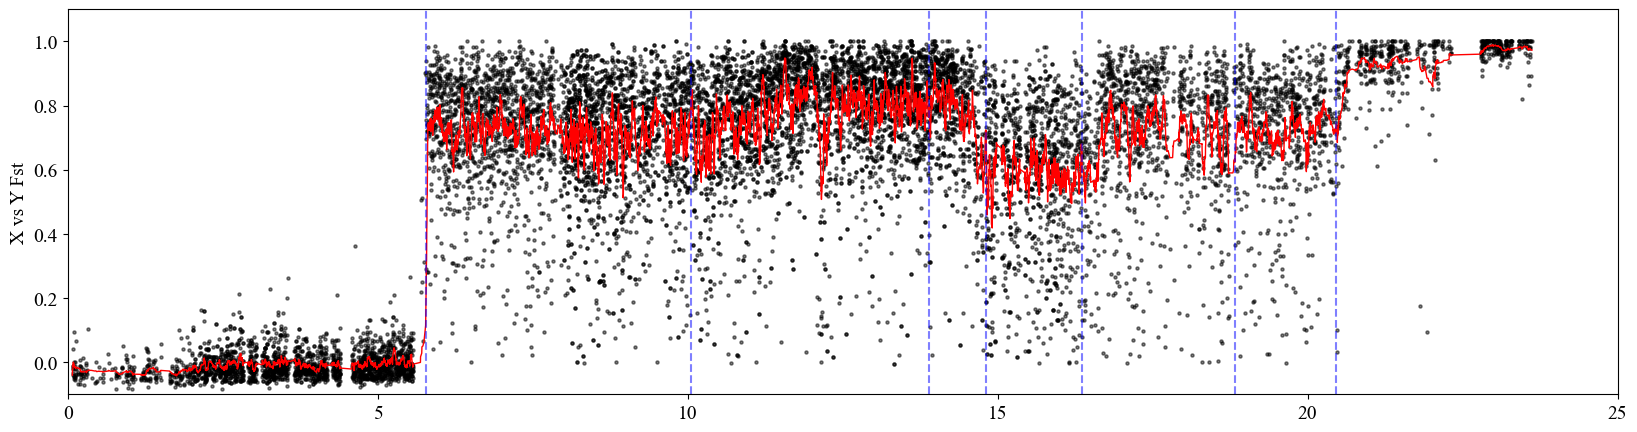

In [191]:
chr12_positions, MFFst_outDF = Plot_M_F_Fst("/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/data/popgen_stats/Gw.FvsM.win1k.2nwindow.fst",
                           "/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/plots/M_F_stats_plots/Gw/fst/Gw_Chr12_FvsM_Fst_2nwindows.pdf",
                           sex_scaffs = ["chr12"],
                           points_color="black",
                           rolling_avg=True,
                           roll=25,
                           rolling_colour="red",
                           myXlims = (0,25), 
                           myYlims_ax1 = (-0.1,1.1),
                           vert_seps=[i/1000000 for i in anchor_genes_chr12.values()],
                           vert_seps_color="blue",
                           y_label="X vs Y Fst")
              

### Changepoint analysis

Calculated using ruptures: 
https://github.com/deepcharles/ruptures/tree/master  
C. Truong, L. Oudre, N. Vayatis. Selective review of offline change point detection methods. Signal Processing, 167:107299, 2020.


In [142]:
import ruptures as rpt
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [193]:
MF_Fst_arr = pd.DataFrame.to_numpy(MFFst_outDF)
algo = rpt.Pelt(model="rbf").fit(MFFst_outDF)

In [196]:
## find indices for the changepoints
result = algo.predict(pen=20)

In [203]:
## get the real positions for the changepoints
changepoints = []

for i in result:
    changepoints.append(chr12_positions[i-1])

In [205]:
changepoints

[5.6945005, 11.1715005, 14.5965005, 16.6145005, 20.5805005, 23.6215005]

Now just replot with these vertical separators

Plotting scaffolds: chr12


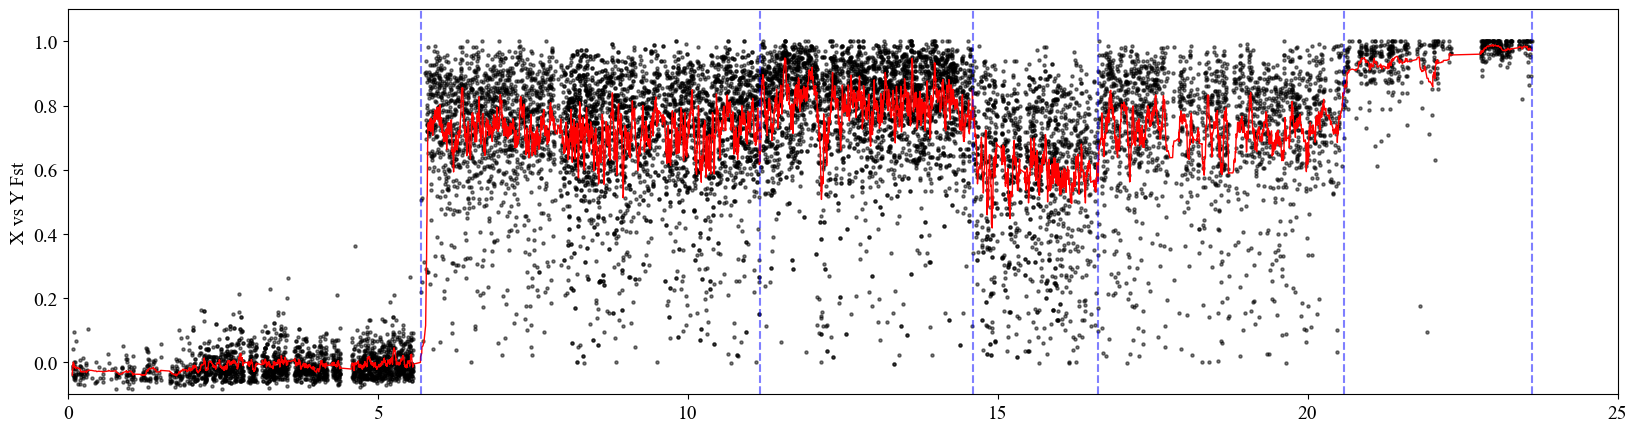

In [204]:
chr12_positions, MFFst_outDF = Plot_M_F_Fst("/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/data/popgen_stats/Gw.FvsM.win1k.2nwindow.fst",
                           "/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/plots/M_F_stats_plots/Gw/fst/Gw_Chr12_FvsM_Fst_2nwindows.pdf",
                           sex_scaffs = ["chr12"],
                           points_color="black",
                           rolling_avg=True,
                           roll=25,
                           rolling_colour="red",
                           myXlims = (0,25), 
                           myYlims_ax1 = (-0.1,1.1),
                           vert_seps=changepoints,
                           vert_seps_color="blue",
                           y_label="X vs Y Fst")
              

#### Chromosome 19

In [84]:
anchor_genes_chr19 = {}

anchor_genes_chr19["g10269.t1"] = 1152759
anchor_genes_chr19["g11226.t1"] = 21347899

anchor_genes_chr19["g10770.t1"] = 14416541  ## this is the ortholog of the boundary gene of S1 in Ga

Plotting scaffolds: chr19


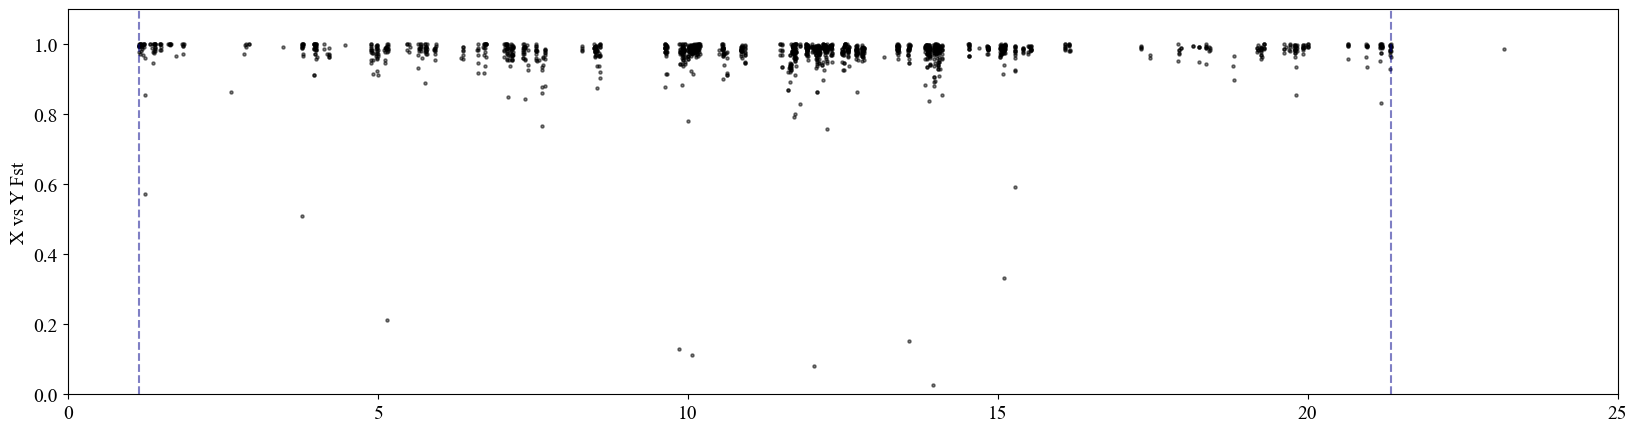

""


In [43]:
Plot_M_F_Fst("/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/data/popgen_stats/Gw.FvsM.win1k.2nwindow.fst",
             "/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/plots/M_F_stats_plots/Gw/fst/Gw_Chr19_FvsM_Fst_2nwindows.pdf",
              sex_scaffs = ["chr19"],
              points_color="black",
              rolling_avg=False,
              rolling_colour="red",
              myXlims = (0,25), 
              myYlims_ax1 = (0,1.1),
              vert_seps=[i/1000000 for i in anchor_genes_chr19.values()],
              y_label="X vs Y Fst")
              

No point in doing a changepoint here. 

### Plotting dS
Calculated using PRANK

#### Chromosome 12

I am not going to try the changepoint analyses here as the data are just too sparse. However, I given these boundaries are now defined robustly based on synteny AND changepoint analysis in the Fst plot, I feel better about calculating mean dNdS for the different regions here, and calculating significance between them. 

In [208]:
changepoints

[5.6945005, 11.1715005, 14.5965005, 16.6145005, 20.5805005, 23.6215005]

In [236]:
mean_regions = [[5.6945005, 11.1715005,],
                [11.1715005, 14.5965005],
                [14.5965005, 16.6145005], 
                [16.6145005, 20.5805005], 
                [20.5805005, 23.6215005]]

Plotting scaffolds: chr12


/Users/dj20y461/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


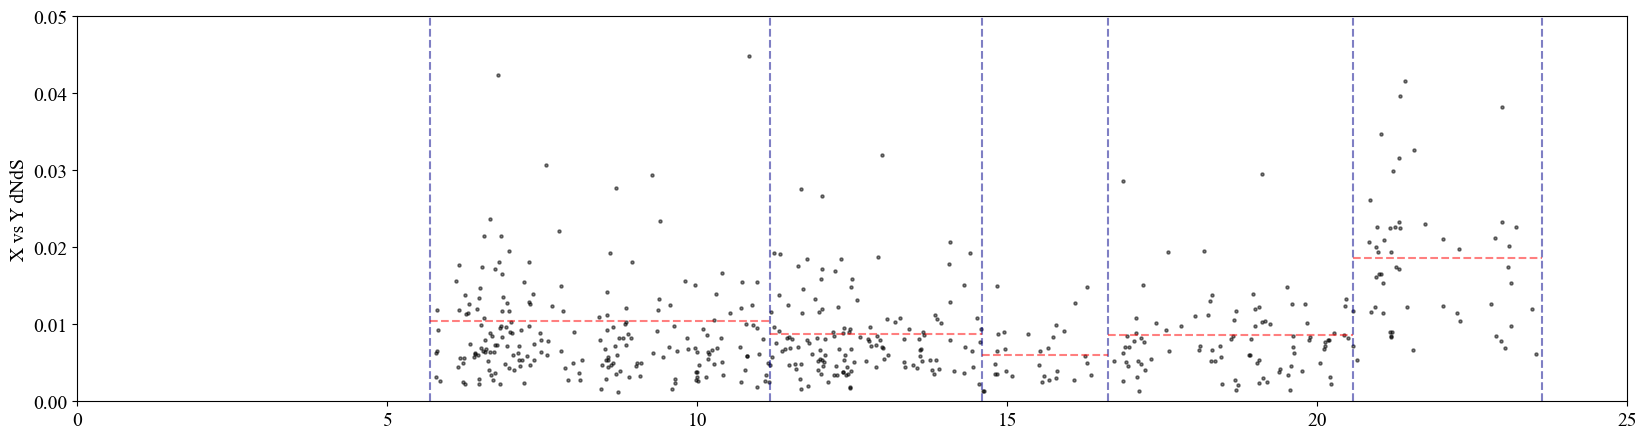

In [293]:
chr12_pos_dS_pddf = Plot_M_F_dS("/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/data/popgen_stats/Gw.dNdS.090824.results",
              "/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/plots/M_F_stats_plots/Gw/dNdS/Gw_dS_chr12.pdf",
              sex_scaffs = ["chr12"],
              points_color="black",
              myXlims = (0,25), 
              myYlims_ax1 = (0,0.05),
              rolling_avg=False,
              strata_avgs = mean_regions,
              vert_seps=changepoints,
              y_label="X vs Y dNdS")

#### Chromosome 19

In [290]:
mean_regions_chr19 = [[1.152759, 14.416541,],
                      [14.416541, 21.347899]]

Plotting scaffolds: chr19


/Users/dj20y461/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


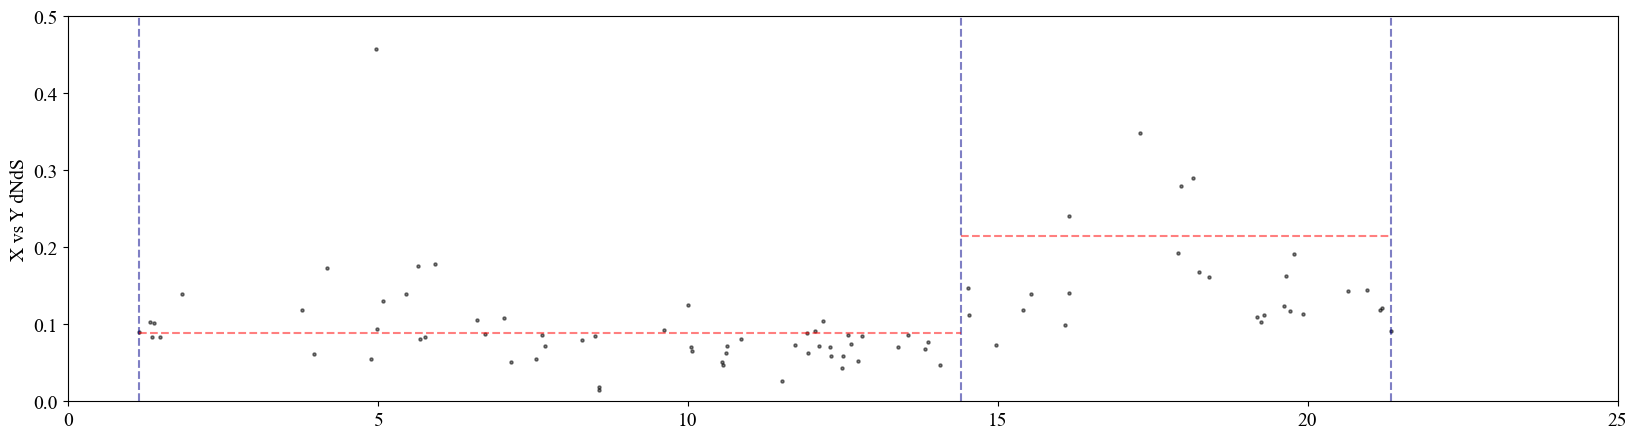

In [294]:
Plot_M_F_dS("/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/data/popgen_stats/Gw.dNdS.090824.results",
              "/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/plots/M_F_stats_plots/Gw/dNdS/Gw_dS_chr19.pdf",
              sex_scaffs = ["chr19"],
              points_color="black",
              myXlims = (0,25), 
              myYlims_ax1 = (0,0.5),
              rolling_avg=False,
              strata_avgs = mean_regions_chr19,
              vert_seps=[i/1000000 for i in anchor_genes_chr19.values()],
              y_label="X vs Y dNdS")

### Plotting dNdS


#### Chromosome 12

Plotting scaffolds: chr12


/Users/dj20y461/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


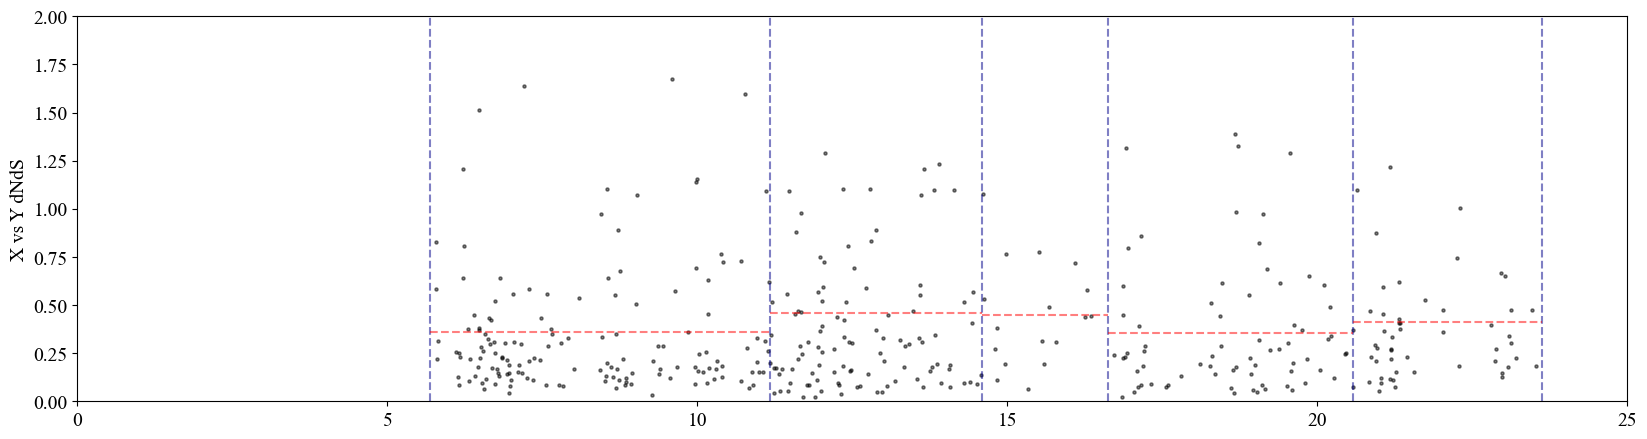

In [295]:
Plot_M_F_dNdS("/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/data/popgen_stats/Gw.dNdS.090824.results",
              "/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/plots/M_F_stats_plots/Gw/dNdS/Gw_dNdS_chr12.pdf",
              sex_scaffs = ["chr12"],
              points_color="black",
              myXlims = (0,25), 
              myYlims_ax1 = (0,2),
              rolling_avg=False,
              strata_avgs = mean_regions,
              vert_seps=changepoints,
              y_label="X vs Y dNdS")

I am not going to try the changepoint analyses here as the data are just too sparse. However, I given these boundaries are now defined robustly based on synteny AND changepoint analysis in the Fst plot, I feel better about calculating mean dNdS for the different regions here, and calculating significance between them. 

#### Chromosome 19

Plotting scaffolds: chr19


/Users/dj20y461/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


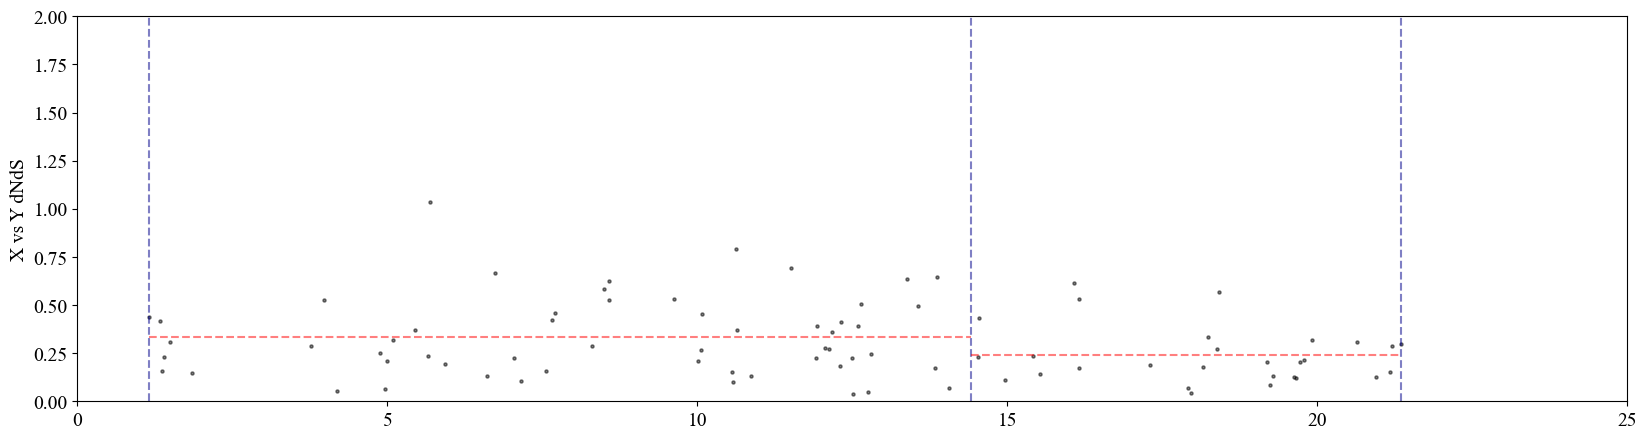

In [296]:
Plot_M_F_dNdS("/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/data/popgen_stats/Gw.dNdS.090824.results",
              "/Users/dj20y461/Data_temp/Stickleback/Stickle_Y_comp/plots/M_F_stats_plots/Gw/dNdS/Gw_dNdS_chr19.pdf",
              sex_scaffs = ["chr19"],
              points_color="black",
              myXlims = (0,25), 
              myYlims_ax1 = (0,2),
              rolling_avg=False,
              strata_avgs = mean_regions_chr19,
              vert_seps=[i/1000000 for i in anchor_genes_chr19.values()],
              y_label="X vs Y dNdS")